In [42]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, DataFrames, Statistics, MLJ, Plots, Clustering

In [3]:
# J = n of points
# I clusters
# D = dimension
# points[j,d]

### synthtic points

function generate_points(I,J,D, std, seed = 1234)
    Random.seed!(seed);
    X, yy = make_blobs(J, D; centers=I, cluster_std=std)
    points = Matrix(DataFrame(X));
    min = minimum(points, dims=1);
    max = maximum(points, dims=1);
    points = (points .- min) ./ (max .- min);
    return points
end

generate_points (generic function with 2 methods)

In [ ]:
#I,J,D = 3, 100, 2
#std = [1,2,3]

points = generate_points(3,100,2, [1,2,3]);
#centroids, assigment, obj_value = manhattan_optimal_kmenas(points, I, J, D);

### KMeans

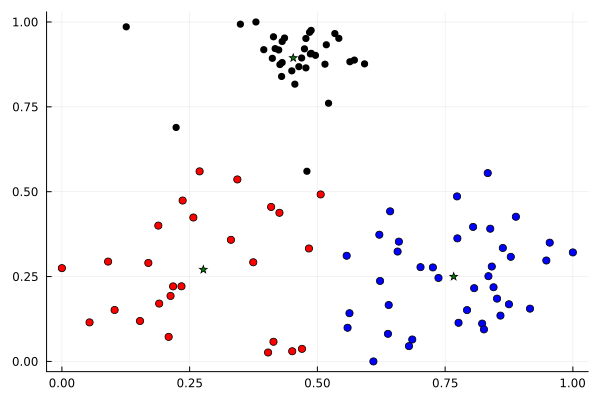

In [10]:
km = kmeans(points', 3);
centroids = km.centers';
assignments = km.assignments;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

### Model 1

In [23]:
function manhattan_optimal_kmeans(points, I, J, D, M)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], M*(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

manhattan_optimal_kmeans (generic function with 1 method)

In [24]:
function euclidean_optimal_kmeans(points,  I, J, D, M)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model,[i=1:I, j=1:J, d=1:D], [y[j,d,i]; x[i,d] - points[j,d]] in SecondOrderCone())

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], M*(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

euclidean_optimal_kmeans (generic function with 1 method)

In [19]:
centroids, assigment, obj_value = manhattan_optimal_kmeans(points, 3, 100, 2, 5);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2500 rows, 1606 columns and 6000 nonzeros
Model fingerprint: 0x14cef6f6
Variable types: 1306 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Presolve removed 924 rows and 612 columns
Presolve time: 0.01s
Presolved: 1576 rows, 994 columns, 3852 nonzeros
Variable types: 694 continuous, 300 integer (300 binary)
Found heuristic solution: objective 46.7648104

Root relaxation: objective -5.216852e+01, 1025 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

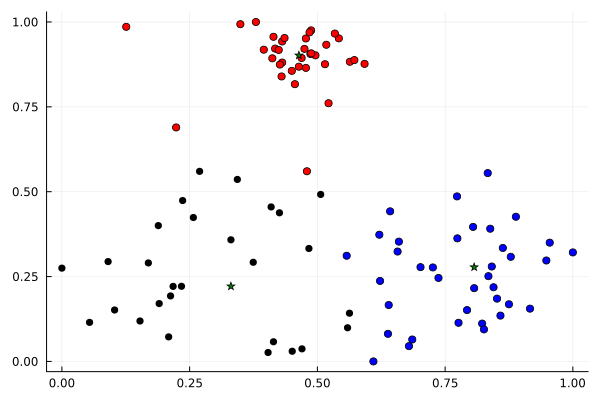

In [20]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assigment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [25]:
centroids, assigment, obj_value = euclidean_optimal_kmeans(points,  3, 100, 2, 5);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2200 rows, 2806 columns and 5100 nonzeros
Model fingerprint: 0x22a42b81
Model has 600 quadratic constraints
Variable types: 2506 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Presolve removed 722 rows and 1910 columns
Presolve time: 0.01s
Presolved: 1478 rows, 896 columns, 3888 nonzeros
Variable types: 596 continuous, 300 integer (300 binary)
Found heuristic solution: objective 45.9687349

Root relaxation: objective -2.780563e+02, 982 iterations, 0.02 seconds (0.02 work units)

    Nodes  

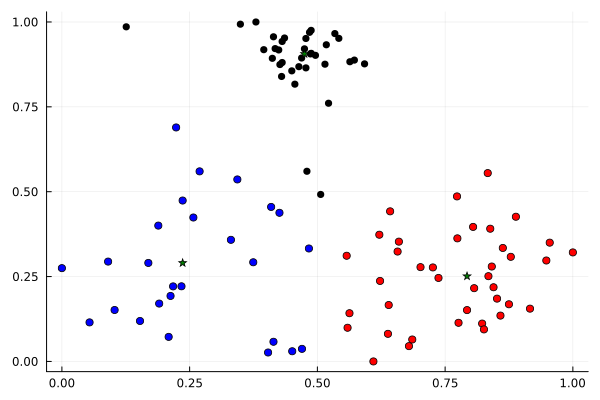

In [26]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assigment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

### Model 2 final

In [28]:
function final_opti_manhattan(points, I, J, D, M, lambda)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 200)
    ### 1)
    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);
    ### 2)
    @variable(model, ksi[i=1:I, j=1:I, l=1:D] >=0);

    ### 1)
    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);
    @constraint(model, [i=1:I, j=1:J], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));
    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);
    @constraint(model, [i = 1:I, j = 1:J], M*(1-z[j,i]) >= mu[j,i]);
    ### 2)
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] >= x[i,l] - x[j,l]);
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] >= x[j,l] - x[i,l]);
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] <= 5);
    @constraint(model, [i=1:I, l=1:D], ksi[i,i,l] == 0);

    @objective(model, Min, lambda*sum(gamma[j] for j=1:J) + (1-lambda)*(-sum(ksi[i,j,l] for i=1:I, j=1:I, l=1:D)));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

final_opti_manhattan (generic function with 1 method)

In [33]:
function final_opti_euclidian(points, I, J, D, M, lambda)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 200)
    ### 1)
    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);
    ### 2)
    @variable(model, ksi[i=1:I, j=1:I, l=1:D] >=0);

    ### 1)
    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);
    @constraint(model, [i=1:I, j=1:J], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model,[i=1:I, j=1:J, d=1:D], [y[j,d,i]; x[i,d] - points[j,d]] in SecondOrderCone())
    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);
    @constraint(model, [i = 1:I, j = 1:J], M*(1-z[j,i]) >= mu[j,i]);
    ### 2)
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] >= x[i,l] - x[j,l]);
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] >= x[j,l] - x[i,l]);
    @constraint(model, [i=1:I, j=1:I, l=1:D], ksi[i,j,l] <= 5);
    @constraint(model, [i=1:I, l=1:D], ksi[i,i,l] == 0);

    @objective(model, Min, lambda*sum(gamma[j] for j=1:J) + (1-lambda)*(-sum(ksi[i,j,l] for i=1:I, j=1:I, l=1:D)));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

final_opti_euclidian (generic function with 1 method)

In [29]:
centroids, assigment, obj_value = final_opti_manhattan(points, 3, 100, 2, 0.6);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12
Set parameter TimeLimit to value 200
Set parameter TimeLimit to value 200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2260 rows, 1624 columns and 5208 nonzeros
Model fingerprint: 0xbe7fe7c9
Variable types: 1324 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [4e-01, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Found heuristic solution: objective 36.6130407
Presolve removed 760 rows and 724 columns
Presolve time: 0.01s
Presolved: 1500 rows, 900 columns, 3900 nonzeros
Variable types: 600 continuous, 300 integer (300 binary)

Root relaxation: objective -1.959411e+02, 894 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

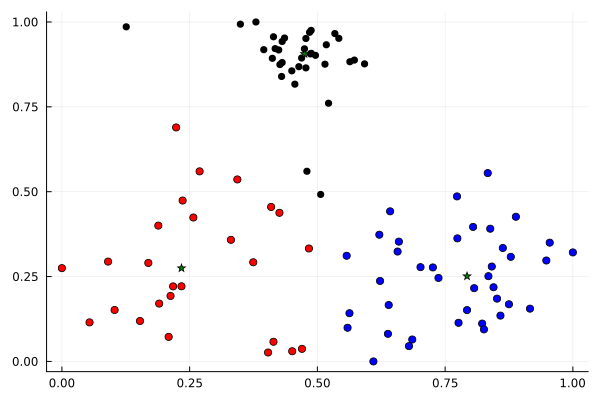

In [31]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assigment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [35]:
centroids, assigment, obj_value = final_opti_euclidian(points, 3, 100, 2, 5, 0.6);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-12
Set parameter TimeLimit to value 200
Set parameter TimeLimit to value 200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2260 rows, 2824 columns and 5208 nonzeros
Model fingerprint: 0x53f89be5
Model has 600 quadratic constraints
Variable types: 2524 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Presolve removed 760 rows and 1924 columns
Presolve time: 0.01s
Presolved: 1500 rows, 900 columns, 3900 nonzeros
Variable types: 600 continuous, 300 integer (300 binary)
Found heuristic solution: objective 3.7617858

Root relaxation: objective -1.959411e+02, 894 iterations, 0.02 seconds (0.01 work units)

    Nodes   

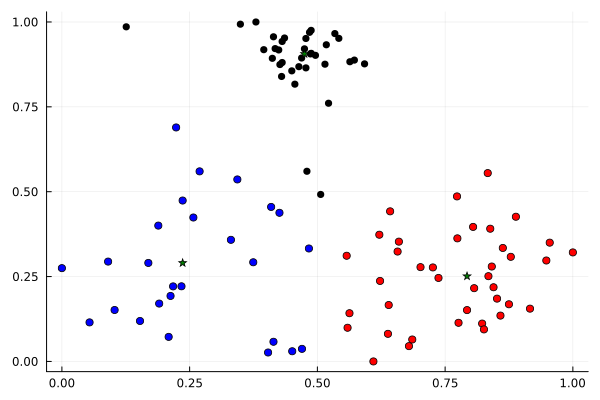

In [36]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assigment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [76]:
### read csv as a matrix
spotify = CSV.read("../spotify2.csv", DataFrame)
spotify = Matrix(spotify)

200×2 Matrix{Float64}:
 66.0  0.0653
 67.0  0.357
 70.0  0.11
 60.0  0.204
 69.0  0.0833
 67.0  0.143
 62.0  0.176
 69.0  0.111
 68.0  0.637
 67.0  0.0919
 58.0  0.124
 67.0  0.133
 67.0  0.374
  ⋮    
 46.0  0.834
 67.0  0.109
 65.0  0.0612
 56.0  0.106
 42.0  0.0782
 58.0  0.0693
 74.0  0.199
 65.0  0.0836
 64.0  0.242
 51.0  0.143
 63.0  0.225
 83.0  0.335

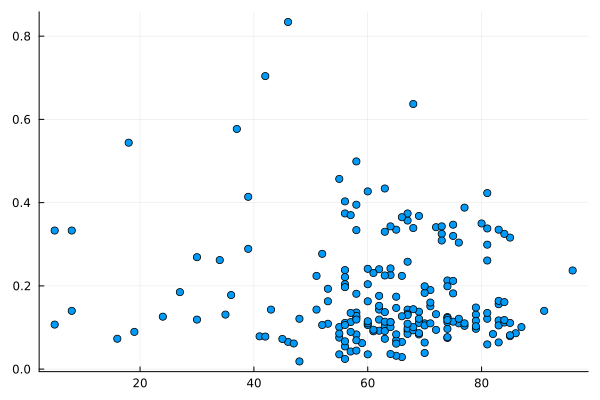

In [82]:
plot(spotify[:,1], spotify[:,2], seriestype=:scatter, legend=false)

In [84]:
km = kmeans(spotify', 3);
centroids = km.centers';
assignments = km.assignments;

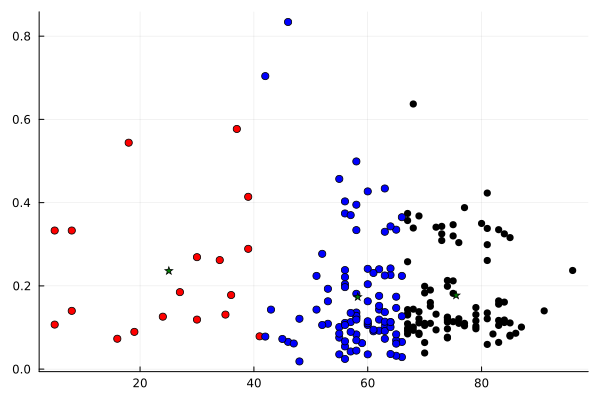

In [87]:
km = kmeans(spotify', 3);
centroids = km.centers';
assignments = km.assignments;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(spotify[:,1], spotify[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [88]:
centroids, assigment, obj_value = euclidean_optimal_kmeans(spotify,  3, 200, 2, 1000);

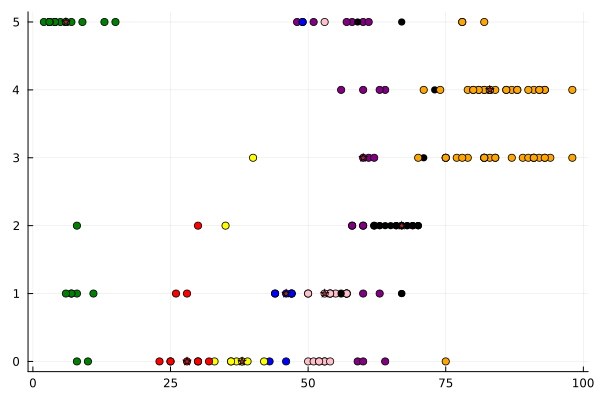

In [ ]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(spotify[:,1], spotify[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [ ]:
centroids, assigment, obj_value = final_opti_euclidian(points, 3, 200, 2, 1000, 0.6);

In [ ]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(spotify[:,1], spotify[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)